In [ ]:

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

^C
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# Install kagglehub
%pip install kagglehub

import kagglehub

# extract features from image
features = {}

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

# Update directory to use the downloaded path
directory = os.path.join(path, 'Images').replace("\\", "/")

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = os.path.join(directory, img_name).replace("\\", "/")
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\Abdallah\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1


  0%|          | 0/8091 [00:00<?, ?it/s]

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [8]:
# create the directory if it does not exist
if not os.path.exists(WORKING_DIR):
	os.makedirs(WORKING_DIR)

# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt').replace("\\", "/"), 'r') as f:
    next(f)
    captions_doc = f.read()

In [13]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
len(mapping)

8091

In [15]:
import re  # Importing re for regular expression

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.
            caption = re.sub(r'[^a-z\s]', '', caption)  # using regex to remove non-alphabetic characters
            # delete additional spaces
            caption = re.sub(r'\s+', ' ', caption).strip()  # remove extra spaces and leading/trailing spaces
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption


In [16]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
# preprocess the text
clean(mapping)

In [18]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
len(all_captions)

40455

In [21]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [23]:
vocab_size

8768

In [24]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [25]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [26]:


# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [27]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [28]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 201s 876ms/step - loss: 5.7813
227/227 ━━━━━━━━━━━━━━━━━━━━ 201s 887ms/step - loss: 4.0431
227/227 ━━━━━━━━━━━━━━━━━━━━ 197s 869ms/step - loss: 3.5761
227/227 ━━━━━━━━━━━━━━━━━━━━ 202s 888ms/step - loss: 3.2921
227/227 ━━━━━━━━━━━━━━━━━━━━ 213s 938ms/step - loss: 3.0821
227/227 ━━━━━━━━━━━━━━━━━━━━ 215s 949ms/step - loss: 2.9265
227/227 ━━━━━━━━━━━━━━━━━━━━ 217s 957ms/step - loss: 2.8131
227/227 ━━━━━━━━━━━━━━━━━━━━ 220s 971ms/step - loss: 2.7216
227/227 ━━━━━━━━━━━━━━━━━━━━ 220s 971ms/step - loss: 2.6396
227/227 ━━━━━━━━━━━━━━━━━━━━ 217s 955ms/step - loss: 2.5638
227/227 ━━━━━━━━━━━━━━━━━━━━ 211s 931ms/step - loss: 2.5004
227/227 ━━━━━━━━━━━━━━━━━━━━ 211s 930ms/step - loss: 2.4442
227/227 ━━━━━━━━━━━━━━━━━━━━ 214s 941ms/step - loss: 2.3937
227/227 ━━━━━━━━━━━━━━━━━━━━ 206s 908ms/step - loss: 2.3494
227/227 ━━━━━━━━━━━━━━━━━━━━ 203s 896ms/step - loss: 2.3090
227/227 ━━━━━━━━━━━━━━━━━━━━ 202s 891ms/step - loss: 2.2745
227/227 ━━━━━━━━━━━━━━━━━━━━ 206s 906ms/

In [29]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word  # Indented this line to be inside the if statement
    return None


In [31]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [32]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [33]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.533333
BLEU-2: 0.195180
BLEU-1: 0.636364
BLEU-2: 0.356753
BLEU-1: 0.647059
BLEU-2: 0.408635
BLEU-1: 0.577778
BLEU-2: 0.335763
BLEU-1: 0.526316
BLEU-2: 0.284555
BLEU-1: 0.536232
BLEU-2: 0.291747
BLEU-1: 0.546512
BLEU-2: 0.322130
BLEU-1: 0.543478
BLEU-2: 0.321745
BLEU-1: 0.539216
BLEU-2: 0.313953
BLEU-1: 0.545432
BLEU-2: 0.313471
BLEU-1: 0.557203
BLEU-2: 0.325035
BLEU-1: 0.544635
BLEU-2: 0.306490
BLEU-1: 0.542129
BLEU-2: 0.311203
BLEU-1: 0.525541
BLEU-2: 0.292013
BLEU-1: 0.515142
BLEU-2: 0.281132
BLEU-1: 0.505618
BLEU-2: 0.267928
BLEU-1: 0.524064
BLEU-2: 0.277612
BLEU-1: 0.527638
BLEU-2: 0.290755
BLEU-1: 0.516432
BLEU-2: 0.282596
BLEU-1: 0.515556
BLEU-2: 0.283685
BLEU-1: 0.510460
BLEU-2: 0.277978
BLEU-1: 0.512097
BLEU-2: 0.277563
BLEU-1: 0.509649
BLEU-2: 0.278876
BLEU-1: 0.518382
BLEU-2: 0.292746
BLEU-1: 0.530466
BLEU-2: 0.313300
BLEU-1: 0.524306
BLEU-2: 0.306684
BLEU-1: 0.520134
BLEU-2: 0.300346
BLEU-1: 0.511254
BLEU-2: 0.291390
BLEU-1: 0.518750
BLEU-2: 0.295550
BLEU-1: 0.5180

In [71]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    


In [75]:
vgg_model = VGG16() 
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [85]:
show_image = "1001773457_577c3a7d70.jpg"
show_image

'1001773457_577c3a7d70.jpg'

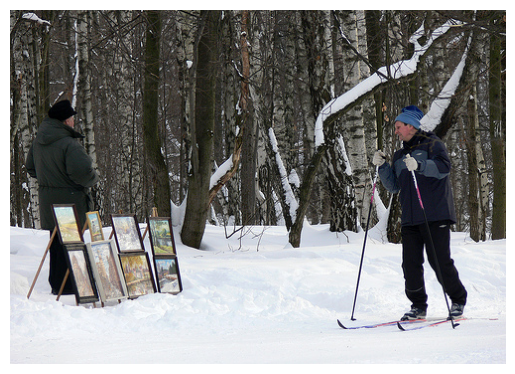

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two people in snow endseq


In [102]:
from PIL import Image

import matplotlib.pyplot as plt

# Load the image
image_path = os.path.join(directory, '101669240_b2d3e7f17b.jpg').replace("\\", "/")
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Print the actual captions
image_id = '101669240_b2d3e7f17b'
captions = mapping[image_id]
print('---------------------Actual---------------------')
for caption in captions:
    print(caption)

# Predict the caption
feature = features[image_id]
predicted_caption = predict_caption(model, feature, tokenizer, max_length)
print('--------------------Predicted--------------------')
print(predicted_caption)

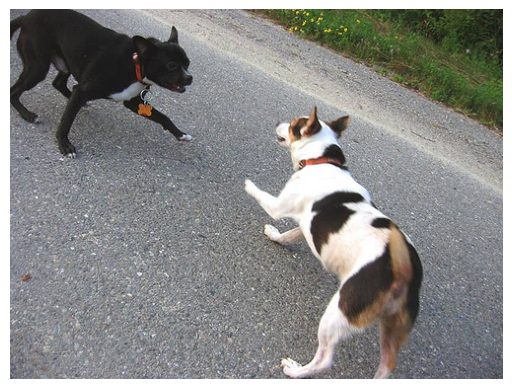

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tricolored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the pavement endseq


In [103]:
from PIL import Image

import matplotlib.pyplot as plt

# Load the image
image_path = os.path.join(directory, '1001773457_577c3a7d70.jpg').replace("\\", "/")
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Print the actual captions
image_id = '1001773457_577c3a7d70'
captions = mapping[image_id]
print('---------------------Actual---------------------')
for caption in captions:
    print(caption)

# Predict the caption
feature = features[image_id]
predicted_caption = predict_caption(model, feature, tokenizer, max_length)
print('--------------------Predicted--------------------')
print(predicted_caption)

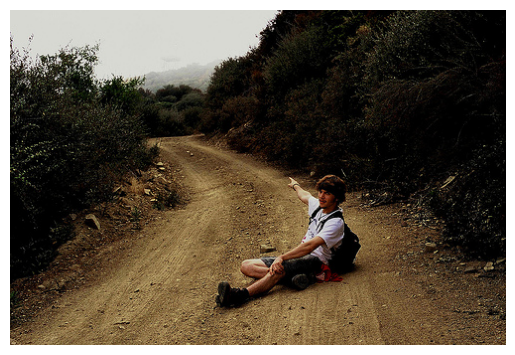

---------------------Actual---------------------
startseq boy pointing in direction on dirt road endseq
startseq boy with backpack sits on trail and points endseq
startseq man points his finger to the path ahead as he sits on the dirt path endseq
startseq man with backpack is sitting in dirt road and pointing toward the horizon endseq
startseq young man sitting in the middle of dirt road pointing up the road endseq
--------------------Predicted--------------------
startseq woman in red hat tosses toddler on the beach endseq


In [111]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Select a random image
random_image_id = random.choice(image_ids)
image_path = os.path.join(directory, random_image_id + '.jpg').replace("\\", "/")
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Print the actual captions
captions = mapping[random_image_id]
print('---------------------Actual---------------------')
for caption in captions:
    print(caption)

# Predict the caption
feature = features[random_image_id]
predicted_caption = predict_caption(model, feature, tokenizer, max_length)
print('--------------------Predicted--------------------')
print(predicted_caption)